# 2.2 Simple Taylor Decomposition

## Introduction

In the previous tutorial on Sensitivity Analysis, we were unable to determine *why* an image $x$ led to $f(x)$. In this tutorial, we will attempt to answer that question with Taylor decomposition. Before we go into the algorithm itself, let us first briefly review what we learned about Taylor expansion in elementary Calculus, as it will be helpful in understanding the content that follows.

In Calculus, a Taylor series is a representation of a function as an infinite sum of terms that are calculated from the values of the function's derivatives at a single point. Given $f(x)$, a function that is infinitely differentiable at a real or complex number $a$, it can be expanded with Taylor expansion as

\begin{align}
f(x) & = f(a) + \frac{f'(a)}{1!}(x - a) + \frac{f''(a)}{2!}(x - a)^2 + \frac{f'''(a)}{3!}(x - a)^3 + \cdots \\
     & = \sum^{\infty}_{n = 0} \frac{f^{(n)}(a)}{n!}(x - a)^n
\end{align}

where $n!$ denotes the factorial of $n$ and $f^{n}(a)$ denotes the $n$th derivative of $f$ evaluated at the point $a$. Expansion of $f(x)$ at $a$ only up until the $k$th derivative is called the $k$th-order Taylor expansion at the root point $a$. $k$th-order Taylor expansion only approximates the function at the point $a$ but becomes more accurate as $k$ becomes larger (approaches infinity).

\begin{equation}
f(x) \approx \sum^{k}_{n = 0} \frac{f^{(n)}(a)}{n!}(x - a)^n
\end{equation}

Note that each term of the Taylor series points out a feature of $f(x)$. For instance, the first term of the series is the value of $f(x)$, the second term is the slope of $f(x)$ and the third term is the curvature of $f(x)$ all evaluated at the point $a$. That is, the Taylor series expansion has decomposed $f(x)$ into meaningful terms. Likewise, the Taylor decomposition is a method that attempts to explain the model's decision by decomposing the function value $f(x)$ as a sum of terms that are meaningful.

Just like Taylor expansion, we will decompose the DNN function $f(x)$ into a sum of terms that are calculated using the function's derivatives at a single point. The Taylor decomposition is obtained by first identifying a root point $\tilde{x}$ for which $f(\tilde{x}) = 0$. You may ask why use the root point $\tilde{x}$? Why not some other point? Quoting the [original paper](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130140) by Bach et al., it is because 

> "we are interested to find out the contribution of each pixel relative to the maximal uncertainty of the prediction which is given by the set of points $f(\tilde{x}) = 0$ since $f(x) > 0$ denotes presence and $f(x) < 0$ absence of the learned structure."

Let me break this sentence down so that it may come more easily. If we expand $f(x)$ at the root point $\tilde{x}$, the we have

\begin{equation}
f(x) = \sum^{V}_{i = 1} \frac{\partial f}{\partial x_i} (\tilde{x}) \cdot (x_i - \tilde{x}_i) + O(xx^\top)
\end{equation}

where $V$ is the number of pixels in the image, $x_i$ is the ith pixel in the input image $x$, $\tilde{x}_i$ is the ith pixel in the root image $\tilde{x}$ and $O(xx^\top)$ contains all higher-order terms. We can simplify the above equation to

\begin{equation}
f(x) \approx \sum^{V}_{i = 1} \frac{\partial f}{\partial x_i} (\tilde{x}) \cdot (x_i - \tilde{x}_i)
\end{equation}

by discarding the higher order terms<sup>[1](#myfootnote1)</sup>. The relevance scores then are given by:

\begin{equation}
R(x_i) = \frac{\partial f}{\partial x_i} (\tilde{x}) \cdot (x_i - \tilde{x}_i)
\end{equation}

The relevance score derived with Taylor decomposition of $f(x)$ now consists of two terms. By thinking about what each term signifies under the context of explaining DNN decisions, we'll hopefully understand why we must expand $f(x)$ with respect to $\tilde{x}$ better.

Let's take a look at the second term $(x_i - \tilde{x}_i)$ first. At first glance, $(x_i - \tilde{x}_i)$ indicates the distance between $x_i$ and $\tilde{x}_i$. However, $\tilde{x}_i$ is located on the decision boundary of the DNN i.e., where the DNN is most uncertain about its decisions. $f(x) < 0$ indicates that $x$ does not contain the object it was trained to recognize. On the other hand, $f(x) > 0$ indicates the presence of the object. But $f(x) = 0$ indicates neither of the cases. Now, if we were given a point $x_p$ which the DNN classified as positive $f(x_p) > 0$, then the difference between the root point and the positive point $(x_p - \tilde{x})$ must be the image of pixels that caused the DNN to classify $x_p$ as positive! Likewise, if we were given a point $x_n$ with $f(x_n) < 0$, $(x_n - \tilde{x})$ is the image of pixels that were the *reason* for DNN's negative decision. Moreover, the absolute value of the differences must indicate how important each pixel was in making the decision. For the sake of brevity, I will call this difference of pixel *'reason pixel'*.

Now, the first term $\partial f / \partial x_i$, as I explained in the Sensitivity Analysis tutorial, tells us what changes in the image (e.g. emphasis or de-emphasis of a particular feature) may cause the DNN to classify the image with more certainty. Therefore, *sensitivity* multiplied by *reason pixel* gives us two information: 1) how influential the pixel was in making the decision through absolute magnitude and 2) whether it had a positive contribution or a negative contribution through its sign. In addition, the sum of *sensitivity* times *reason* must add up to $f(x)$. That is, this algorithm decomposes $f(x)$ into sum of meaningful terms. Therefore it is named Taylor Decomposition.

<a name="myfootnote1">1</a>: Because these higher-order terms are typically non-zero, the relevance scores only provides a partial explanation of $f(x)$. Recall how $k$th-order Taylor expansion with finite $k$ only *approximates* $f(x)$. More specifically, a first-order Taylor expansion is a local linear approximation of $f(x)$ as it models a tangent hyperplane at $f(a)$. Therefore, $\tilde{x}$ should be chosen to be close to $x$ under the Euclidean norm in order to minimize the Taylor residuum according to higher order approximation.

## Simple Taylor Decomposition

The footnote at the previous section claims that discarding higher order terms, as in Eq. (10), leads to loss of accuracy. However, for special functions that are piecewise linear and satisfy the property $f(tx) = tf(x)$ for $t \geq 0$ is not subject to this limitation. We call these functions homogeneous functions, and say that they satisfy the homogeneity property. These special functions include homogeneous linear models or deep Rectified Linear Unit (ReLU) networks without biases<sup>[2](#myfootnote2)</sup>. Networks with bias are not homogeneous. A simple example demonstrates this fact. Consider two ReLU units with and without bias:

$$
\begin{cases}
f(x) = \max (0, ax + b) & \text{ReLU with bias} \\
g(x) = \max (0, a'x) &  \text{ReLU without bias}
\end{cases}
$$

\begin{align}
f(tx) & = \max (0, a(tx) + b) = t \cdot \max (0, ax + \frac{b}{t}) \neq t f(x) \\
g(tx) & = \max (0, a'(tx)) = t \cdot \max (0, ax) = t g(x)
\end{align}

For these homogeneous functions, we can always find a root point $\tilde{x} \approx 0$ for which $f(\tilde{x}) \approx 0$. This simple bit of equations below show why.

\begin{align}
0 \times 0 & = 0 \\
f(0 \times 0) = 0 \times f(0) & = 0 \ \text{(by the homogeneity property)} \\
f(0) & = 0
\end{align}

Moreover, because they are piecewise linear, derivatives of order $2$ and above becomes $0$ (you can prove it with simple application of the chain rule). In other words, $O(xx^\top) = 0$. Therefore the function can be rewritten as

\begin{equation}
f(x) = \sum^{V}_{i = 1} \frac{\partial f}{\partial x_i} \cdot x_i
\end{equation}

where the relevance scores are reduced to

\begin{equation}
R(x_i) = \frac{\partial f}{\partial x_i} \cdot x_i
\end{equation}

Relevance here can be understood as the product of sensitivity $\partial f / \partial x_i$ and saliency $x_i$. That is, an input feature is relevant if it both influences the model's decision and if it is present in the input data. This simple Taylor decomposition will serve as a basis for the more sophisticated deep Taylor decomposition later on in the tutorial.

<a name="myfootnote2">2</a>: ReLU is a type of piecewise-linear activation function given by $f(x) = \max (0, x)$. Therefore its derivative is $1$ for $x > 0$ and all derivatives of higher order are 0.

![title](./assets/2_2_STD/relu.png)

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_2_2 import MNIST_DNN
from utils import pixel_range

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

logdir = './tf_logs/2_2_STD/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In this step, a regular DNN classifier is initialized and necessary nodes for model training is added onto the graph. In this particular tutorial, I used a fully connected neural network with ReLU activations and without bias in order to satisfy the $f(tx) = tf(x)$ property mentioned in the introduction.

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_DNN('DNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    logits = DNN(X)

    tf.add_to_collection('STD', X)
    tf.add_to_collection('STD', logits)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

This is the step where the DNN is trained to classify the 10 digits of the MNIST images. Summaries are written into the logdir and you can visualize the statistics using tensorboard by typing this command: `tensorboard --lodir=./tf_logs`

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

sess.close()

Epoch: 0001 cost = 0.219089266 accuracy = 0.932654549
Epoch: 0002 cost = 0.094108313 accuracy = 0.970509098
Epoch: 0003 cost = 0.063319880 accuracy = 0.981018193
Epoch: 0004 cost = 0.052812036 accuracy = 0.984163647
Epoch: 0005 cost = 0.040355152 accuracy = 0.987472736
Epoch: 0006 cost = 0.034566203 accuracy = 0.989272737
Epoch: 0007 cost = 0.030482266 accuracy = 0.990836371
Epoch: 0008 cost = 0.027112952 accuracy = 0.991836370
Epoch: 0009 cost = 0.025552069 accuracy = 0.992618188
Epoch: 0010 cost = 0.022734434 accuracy = 0.993200006
Epoch: 0011 cost = 0.021561455 accuracy = 0.993254552
Epoch: 0012 cost = 0.021590023 accuracy = 0.993672733
Epoch: 0013 cost = 0.014020874 accuracy = 0.996000004
Epoch: 0014 cost = 0.017473234 accuracy = 0.995145459
Epoch: 0015 cost = 0.018183533 accuracy = 0.995272731
Accuracy: 0.9799


### 4. Restoring Subgraph

Here we first rebuild the DNN graph from metagraph, restore CNN parameters from the checkpoint and then gather the necessary nodes for prototype generation using the `tf.get_collection()` function (recall prototype subgraph nodes were added onto the 'sensitivity analysis' collection at step 2). We now can calculate the relevance scores by multiplying the gradient calculated by `tf.gradients()` function with `X`.

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

nodes = tf.get_collection('STD')
X = nodes[0]
logits = nodes[1]

STD_score = tf.negative(X * tf.gradients(logits, X))

INFO:tensorflow:Restoring parameters from ./tf_logs/2_2_STD/model


### 5. Calculating Relevance Scores $R(x_i)$

In [5]:
images = mnist.train.images
labels = mnist.train.labels

sample_imgs = []
for i in range(10):
    sample_imgs.append(images[np.argmax(labels, axis=1) == i][3])

hmaps = sess.run(STD_score, feed_dict={X: sample_imgs})

sess.close()

### 6. Displaying Images

The gradients are visualized as heat maps over the original digit images. You can see which features/data points influenced the DNN most its decision making. Also note that unlike simple sensitivity analysis, the heat map points out features strictly within the digit due to the saliency constraint.

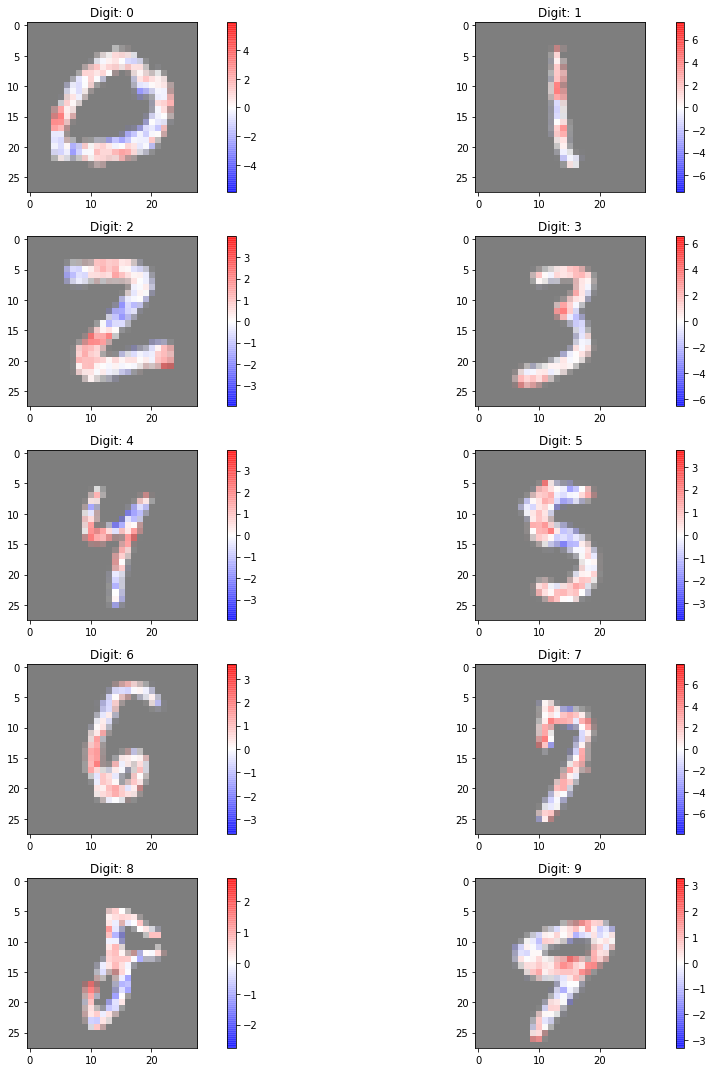

In [6]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(np.reshape(sample_imgs[2 * i], [28, 28]), cmap='gray')
    
    vmin, vmax = pixel_range(hmaps[0][2 * i])
    plt.imshow(np.reshape(hmaps[0][2 * i], [28, 28]), vmin=vmin, vmax=vmax, cmap='bwr', alpha=0.5)
    plt.title('Digit: {}'.format(2 * i))
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(np.reshape(sample_imgs[2 * i + 1], [28, 28]), cmap='gray')
    
    vmin, vmax = pixel_range(hmaps[0][2 * i + 1])
    plt.imshow(np.reshape(hmaps[0][2 * i + 1], [28, 28]), vmin=vmin, vmax=vmax, cmap='bwr', alpha=0.5)
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.colorbar()

plt.tight_layout()